# Прогнозирование уровня средней заработной платы в России

In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as sts
%matplotlib inline

In [3]:
# Загрузка данных
data = pd.read_csv("WAG_C_M.csv", delimiter=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


C:\Users\egore\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


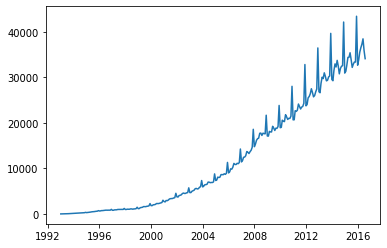

In [4]:
# Визуализация ряда
_ = plt.plot(data.index, data.WAG_C_M)

Критерий Дики-Фуллера: p=0.991850


C:\Users\egore\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\egore\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexes\base.py:459: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


<Figure size 1080x504 with 0 Axes>

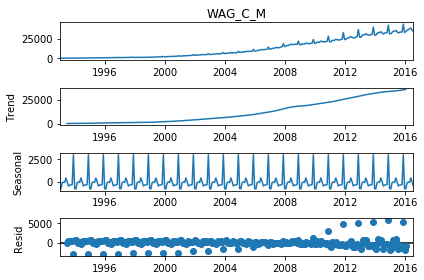

In [20]:
# Проверка стационарности и STL-декомпозиция ряда
plt.figure(figsize=(15, 7))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

На графиках заметно явное наличие тренда, а также сезонные годовые циклы. Гипотеза о нестационарности не отвергается.

Оптимальное значения лямбда: 0.2632017541844584
Критерий Дики-Фуллера: p=0.696899


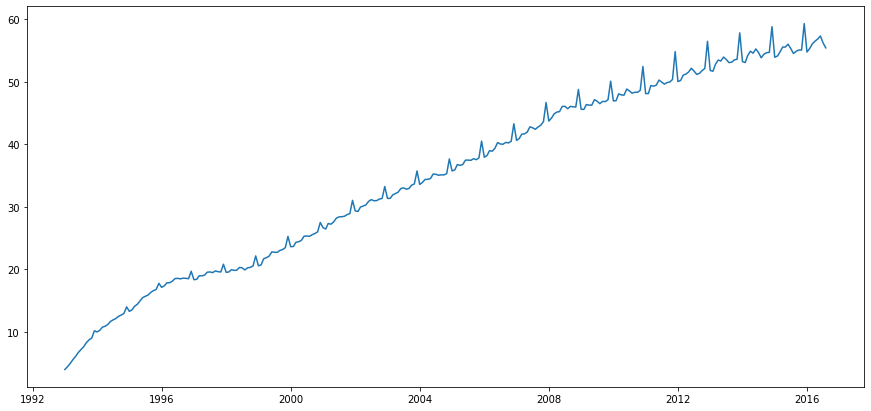

In [6]:
# Преобразование Бокса-Кокса для стабилизации дисперсии
data['boxcox'], lambda_ = sts.boxcox(data.WAG_C_M)
plt.figure(figsize=(15, 7))
plt.plot(data.index, data.boxcox)
print("Оптимальное значения лямбда:", lambda_)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.boxcox)[1])

Дисперсия стабилизировалась, но в данных все равно присутствует тренд.

Критерий Дики-Фуллера: p=0.014697


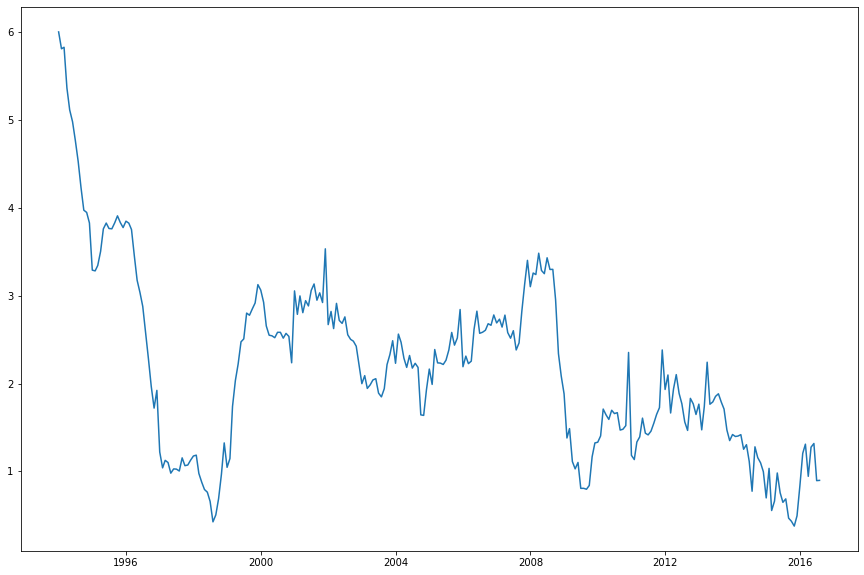

In [7]:
# Дифференцирование ряда (сезонное)
data['boxcox_season_diff'] = data.boxcox - data.boxcox.shift(12)
plt.figure(figsize=(15, 10))
plt.plot(data.index[12:], data.boxcox_season_diff[12:])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.boxcox_season_diff[12:])[1])

Критерий Дики-Фуллера: p=0.014396


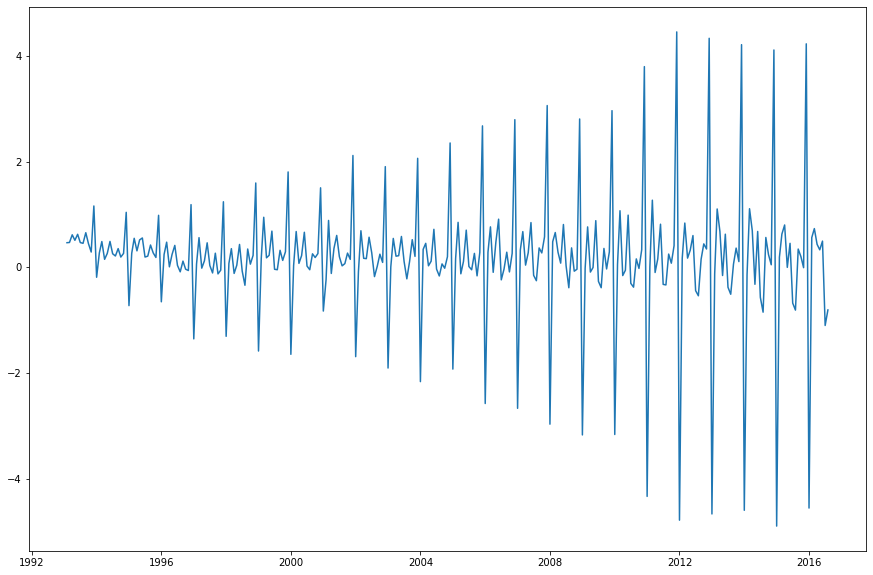

In [8]:
# Однократное дифференцирование
data['boxcox_diff1'] = data.boxcox - data.boxcox.shift(1)
plt.figure(figsize=(15, 10))
plt.plot(data.index[1:], data.boxcox_diff1[1:])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.boxcox_diff1[1:])[1])

Критерий Дики-Фуллера: p=0.000000


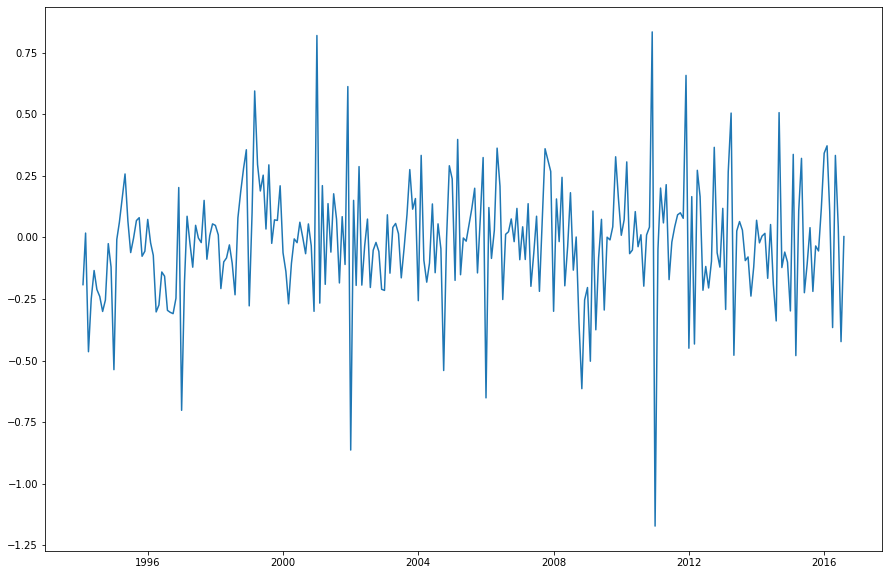

In [9]:
# Однократное + сезоннное дифференцирование ряда
data['boxcox_season_diff1'] = data.boxcox_season_diff - data.boxcox_season_diff.shift(1)
plt.figure(figsize=(15, 10))
plt.plot(data.index[13:], data.boxcox_season_diff1[13:])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.boxcox_season_diff1[13:])[1])

Теперь гипотеза о нестционарности отклонена. Приступим к подбору параметров для модели.

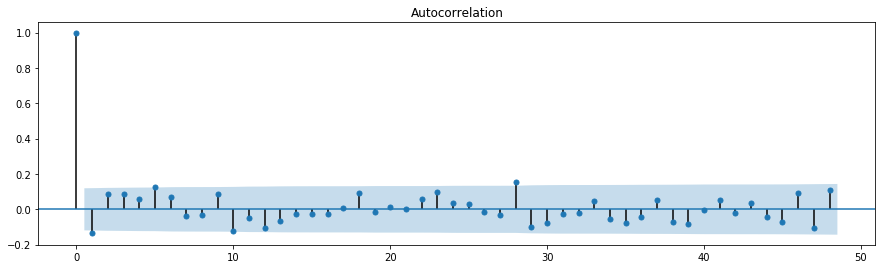

In [10]:
# ACF ряда
plt.figure(figsize=(15,9))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.boxcox_season_diff1[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

Начальное приближение для q = 1, для Q = 0

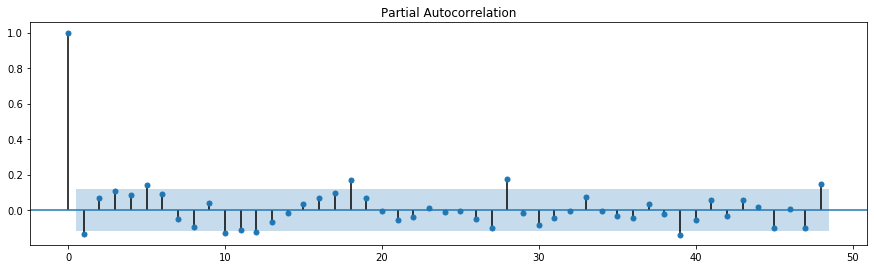

In [11]:
# PACF ряда
plt.figure(figsize=(15,9))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.boxcox_season_diff1[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

Начальное приближение для p = 1, для P = 1

In [12]:
from itertools import product
ps = range(0, 1)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

4

In [13]:
# Подбор лучших параметров модели
import warnings
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [14]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
3  (0, 1, 1, 0)  1.170768
2  (0, 1, 0, 0)  3.369832
1  (0, 0, 1, 0)  4.268898
0  (0, 0, 0, 0)  5.241225


C:\Users\egore\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\egore\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\internals\construction.py:588: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if dtype != object and dtype != np.object:
C:\Users\egore\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexes\base.py:459: DeprecationWarning: `np.bool` is a deprecated alias for th

Идеальные параметры для модели: p = 0, q = 1, P = 1, Q =0.

In [15]:
# Лучшая модель 
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              boxcox   No. Observations:                  284
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                   2.415
Date:                             Tue, 05 Oct 2021   AIC                              1.171
Time:                                     09:20:51   BIC                             11.977
Sample:                                 01-01-1993   HQIC                             5.510
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1269      0.045     -2.808      0.005      -0.215      -0.038
ar.S.L12      -0.1304      

C:\Users\egore\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\egore\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexes\base.py:459: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


Критерий Стьюдента: p=0.092997
Критерий Дики-Фуллера: p=0.000003


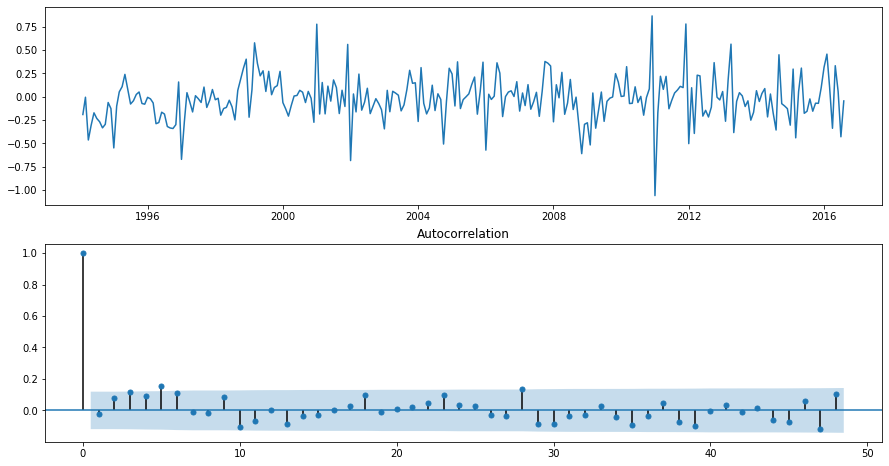

In [16]:
# Анлиз остатков лучшей модели
plt.figure(figsize=(15,8))
plt.subplot(211)
plt.plot(best_model.resid[13:])

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % sts.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (критерий Стюдента не позволил отклонить гипотезу о несмещенности), стационарны (гипотеза о нестационарности отвергается) и неавтокоррелированы (критерий Льюнга-Бокса не позволяет отклонить гипотезу о независимости остатков + анализ автокорреляционной функции остатков не выявил автокорреляции)

C:\Users\egore\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\egore\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexes\base.py:459: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


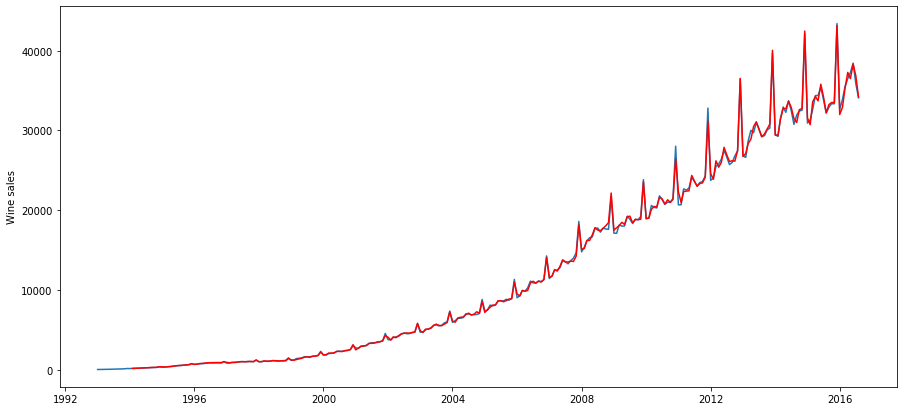

In [17]:
# График истинных и прогнозных значений ряда
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

data['model'] = invboxcox(best_model.fittedvalues, lambda_)
plt.figure(figsize=(15,7))
plt.plot(data.WAG_C_M)
plt.plot(data.model[13:], color='r')
plt.ylabel('Wine sales')
plt.show()

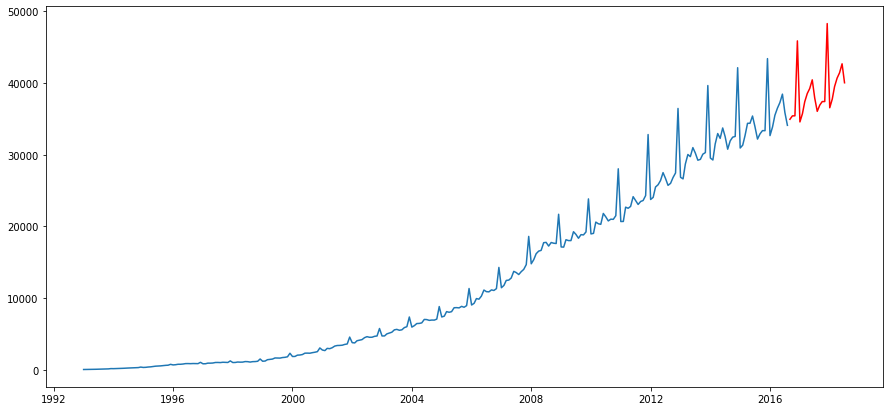

In [18]:
# Прогноз на 2 года
import datetime
from  dateutil.relativedelta import relativedelta
data2 = data[["WAG_C_M"]]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0, 24)]
future = pd.DataFrame(data=data2, index=date_list, columns=data2.columns)
data2= pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=284+24), lambda_)

plt.figure(figsize=(15,7))
plt.plot(data2.WAG_C_M)
plt.plot(data2.forecast, color='r')
plt.show()